In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00:00:010:01
  Attempting uninst

## On Test Data


image 1/1 /kaggle/input/weed-detection-dataset/test/images/agri_0_9430_jpeg.rf.55590fd568cfd05cb5a5f38a69781ce9.jpg: 640x640 1 Crop, 804.6ms
Speed: 4.4ms preprocess, 804.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/weed-detection-dataset/test/images/agri_0_9266_jpeg.rf.190539e7297457c48131e14d0eaf9823.jpg: 640x640 1 Weed, 797.4ms
Speed: 3.1ms preprocess, 797.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/weed-detection-dataset/test/images/agri_0_9881_jpeg.rf.ee55ad20cd1edd1f366c6d2641677d66.jpg: 640x640 1 Weed, 816.9ms
Speed: 3.0ms preprocess, 816.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/weed-detection-dataset/test/images/agri_0_9532_jpeg.rf.cec78142a3ad2cbd2466c222131f846a.jpg: 640x640 1 Weed, 830.8ms
Speed: 3.3ms preprocess, 830.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/weed-detection-

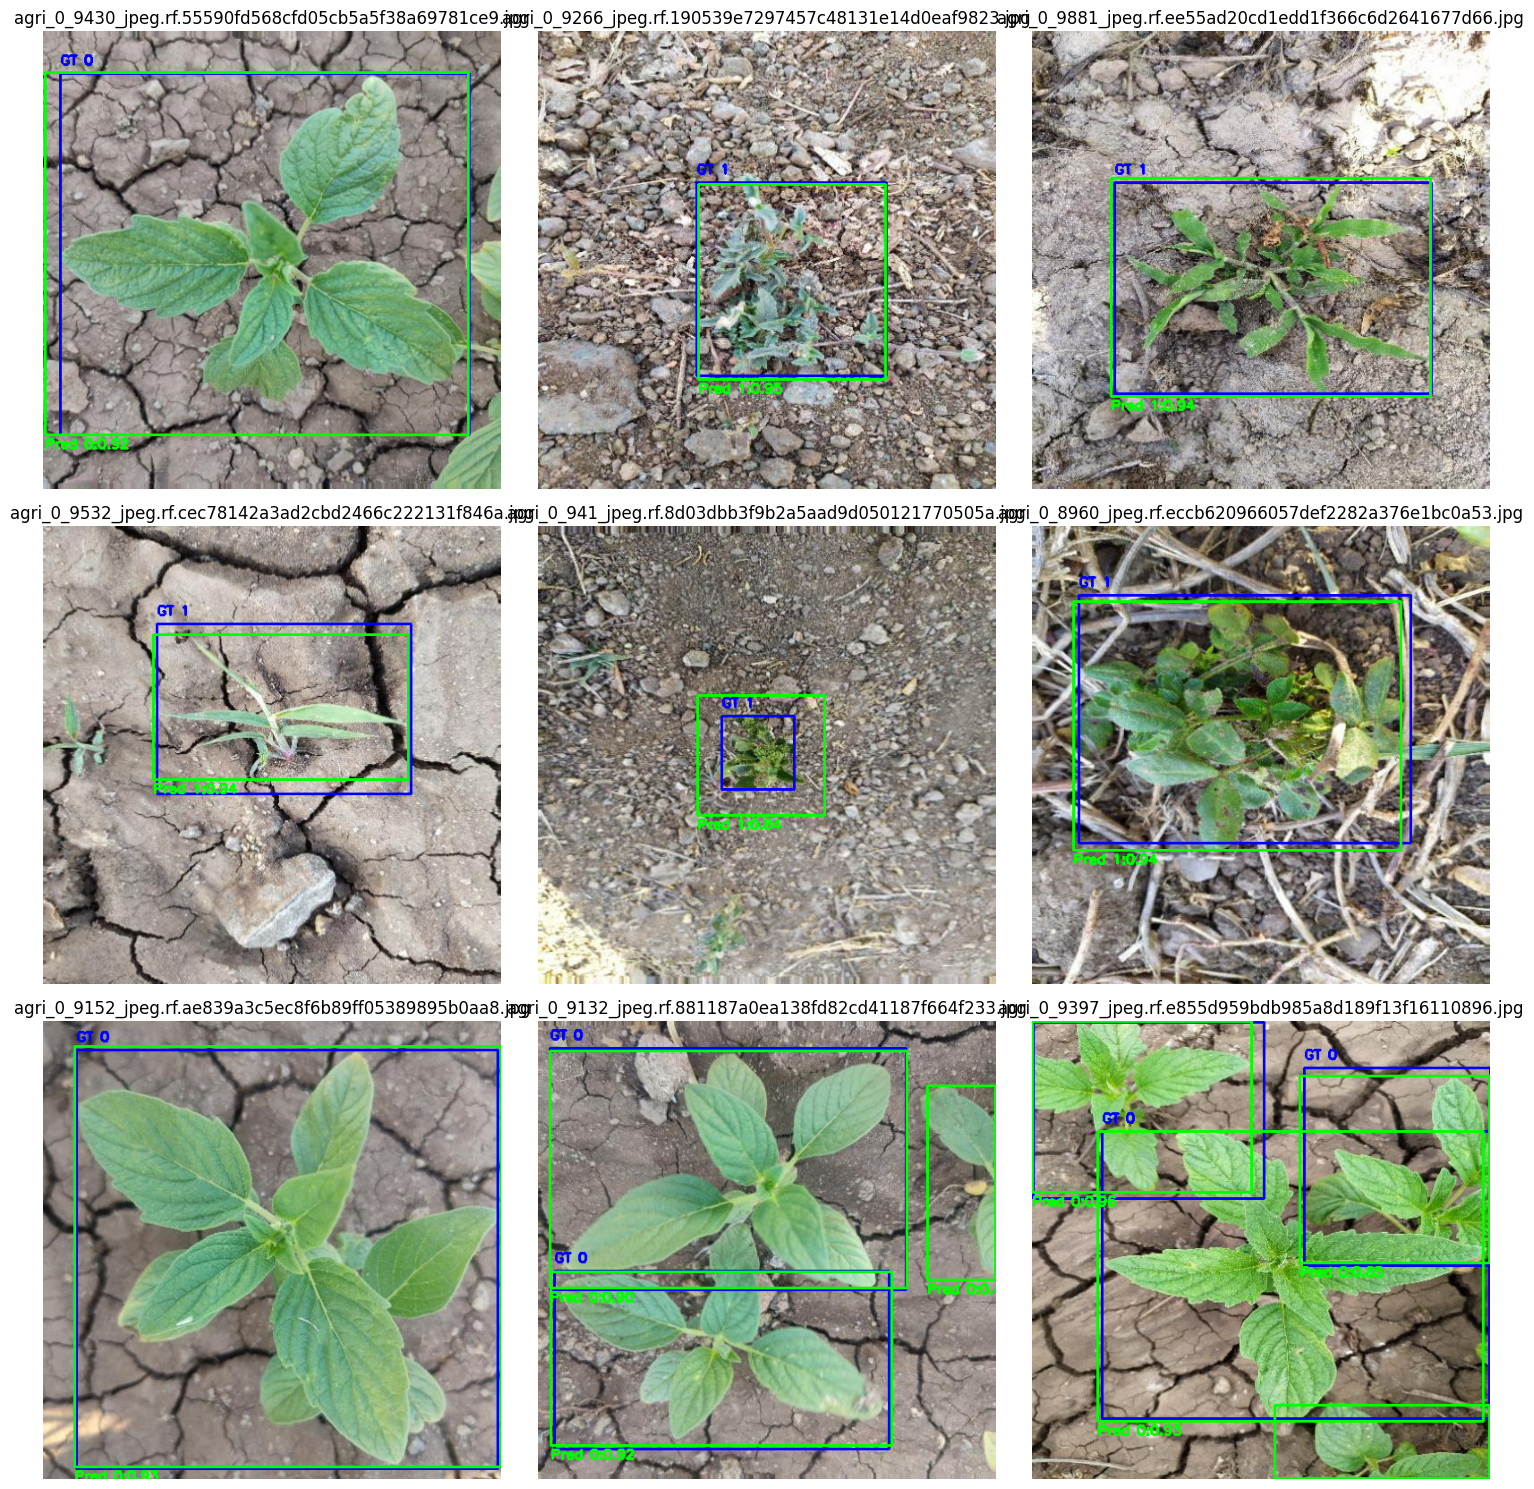

In [21]:
import os
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

def read_yolo_annotations(txt_path, img_w, img_h):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, x, y, w, h = map(float, parts)
            x1 = int((x - w/2) * img_w)
            y1 = int((y - h/2) * img_h)
            x2 = int((x + w/2) * img_w)
            y2 = int((y + h/2) * img_h)
            boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

# Load the model
model = YOLO('/kaggle/input/comparison_model/pytorch/default/1/model_mean_teacher.pt')

# Directory paths
img_dir = '/kaggle/input/weed-detection-dataset/test/images'
ann_dir = '/kaggle/input/weed-detection-dataset/test/annotations'

# Get image files (up to 9 for example)
img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:9]

# Determine grid size
n_cols = 3
n_rows = int(np.ceil(len(img_files) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
axes = axes.flatten()  # flatten in case of 1 row

for ax, img_file in zip(axes, img_files):
    img_path = os.path.join(img_dir, img_file)
    ann_file = os.path.splitext(img_file)[0] + '.txt'
    ann_path = os.path.join(ann_dir, ann_file)
    img = cv2.imread(img_path)
    img_h, img_w = img.shape[:2]

    # Actual boxes
    actual_boxes = read_yolo_annotations(ann_path, img_w, img_h)

    # Predicted boxes
    results = model(img_path)
    pred_boxes = []
    for r in results:
        boxes = r.boxes.xyxy.cpu().numpy() if hasattr(r.boxes, 'xyxy') else []
        confs = r.boxes.conf.cpu().numpy() if hasattr(r.boxes, 'conf') else []
        clss = r.boxes.cls.cpu().numpy() if hasattr(r.boxes, 'cls') else []
        for box, conf, cls in zip(boxes, confs, clss):
            x1, y1, x2, y2 = map(int, box)
            pred_boxes.append((int(cls), x1, y1, x2, y2, conf))

    # Draw actual boxes (red)
    img_show = img.copy()
    for cls, x1, y1, x2, y2 in actual_boxes:
        cv2.rectangle(img_show, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img_show, f'GT {cls}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
    # Draw predicted boxes (green)
    for cls, x1, y1, x2, y2, conf in pred_boxes:
        cv2.rectangle(img_show, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img_show, f'Pred {cls}:{conf:.2f}', (x1, y2+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    # Show image in grid
    img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.axis('off')
    ax.set_title(img_file)

# Hide unused subplots
for i in range(len(img_files), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## On Web image


image 1/1 /kaggle/input/screenshot-2025/Screenshot 2025-09-25 132531.png: 448x640 1 Weed, 581.8ms
Speed: 2.1ms preprocess, 581.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


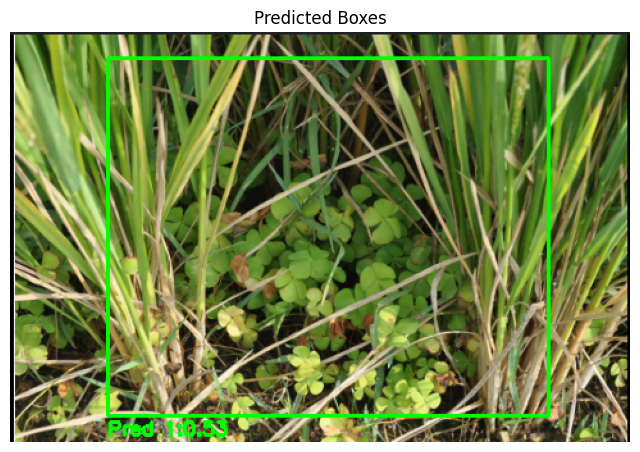

In [3]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load your trained model
model = YOLO('/kaggle/input/model_mean_teacher/pytorch/default/1/model_mean_teacher.pt')

# Path to your custom image
custom_image_path = '/kaggle/input/screenshot-2025/Screenshot 2025-09-25 132531.png'

# Read image
img = cv2.imread(custom_image_path)
img_h, img_w = img.shape[:2]

# Predict with the model
results = model(custom_image_path)
pred_boxes = []
for r in results:
    boxes = r.boxes.xyxy.cpu().numpy() if hasattr(r.boxes, 'xyxy') else []
    confs = r.boxes.conf.cpu().numpy() if hasattr(r.boxes, 'conf') else []
    clss = r.boxes.cls.cpu().numpy() if hasattr(r.boxes, 'cls') else []
    for box, conf, cls in zip(boxes, confs, clss):
        x1, y1, x2, y2 = map(int, box)
        pred_boxes.append((int(cls), x1, y1, x2, y2, conf))

# Draw predicted boxes (green)
img_show = img.copy()
for cls, x1, y1, x2, y2, conf in pred_boxes:
    cv2.rectangle(img_show, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_show, f'Pred {cls}:{conf:.2f}', (x1, y2+15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

# Show the image
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Predicted Boxes')
plt.show()
